[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_HelicalTangled_jet.ipynb)

# Mixing in the AGN jet with helical and tangled component

This tutorial demonstrates the basic usage of the `JetHelicalTangled` magnetic field class, for a blazar jet magnetic field comprised of a helical and a tangled component. Values used for the jet properties come from the best fit of the Potter & Cotter model (<a href="https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.4070P/">Potter & Cotter 2015</a>). The model in the case of ALP mixing is discussed in <a href="https://ui.adsabs.harvard.edu/abs/2020arXiv201108123D/abstract">Davies et al. (2021)</a>.

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

We start with importing the necessary modules and classes:

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from matplotlib.patheffects import withStroke
from astropy import units as u

effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

We will use Markarian 501 as the example source.
In addition to the redshift and sky coordinates, we also provide
the bulk Lorentz factor $\Gamma_\mathrm{L}$ which we assume for the jet through the `bLorentz` key word.
This will be used later in the `JetHelicalTangled` class.

In [5]:
src = Source(z=0.034 , ra='16h53m52.2s', dec='+39d45m37s', bLorentz=9.)  # Mrk501

Set up the module list with arbitrary ALP parameters. The energy range roughly corresponds to CTA energies.

In [6]:
EGeV = np.logspace(0.,5.,2000)

We will use an unpolarised initial beam.

In [7]:
pin = np.diag((1.,1.,0.)) * 0.5

In [8]:
ml = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)

Add the jet module. We will ignore any other magnetic fields. Here we use a field with 70% magnetic energy density in the tangled component, and a helical component which is a purely toroidal field. Values come from <a href="https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.4070P/">Potter & Cotter</a> best fit. For the tangled field coherence length, we use a uniform distribution between 0.1 and 1. times the jet width at each point. This is chosen with the `l_tcor='jetwidth'` and `jwf_dist = 'Uniform'` options. `l_tcor` can also be given as a constant in parsecs, or the keyword `'jetdom'` can be used to used the jet field domains as the tangled domains.

In [9]:
ml.add_propagation("JetHelicalTangled",
                  0,  # position of module counted from the source.
                  ndom=400,
                  ft=0.7,  # fraction of magnetic field energy density in tangled field
                  Bt_exp=-1.,  # exponent of the transverse component of the helical field
                  r_T=0.3,  # radius at which helical field becomes toroidal in pc
                  r0=0.3, # radius where B field is equal to b0 in pc
                  B0=0.8, # Bfield strength in G
                  n0=1.e4,  # electron density at r0 in cm**-3
                  rjet=98.3e+3,  # jet length in pc
                  rvhe=0.3, # distance of gamma-ray emission region from BH in pc
                  alpha=1.68,  # power-law index of electron energy distribution function
                  l_tcor='jetwidth',  # tangled field coherence average length in pc if a constant, or keyword
                  #jwf = 1.,  # jet width factor used when calculating l_tcor = jwf*jetwidth
                  jwf_dist='Uniform' # type of distribution for jet width factors (jwf)
                 )

    jet.py: 569 --- WARNING: Not resolving tangled field: min z step is 0.009857915102843562pc but min tangled length is 0.0011253320407637601 pc
    jet.py: 572 --- WARNING: # of z doms is 399 but # tangled doms is 161
    jet.py: 585 --- INFO: rerunning with 641 domains. new min z step is 0.0002813330101908984 pc
environs.py:1001 --- INFO: Using inputted chi
environs.py:1008 --- INFO: Using inputted chi


The default number of log-spaced field domains is `ndom=400` (this is enough to resolve the field for ALPs). In this case, however, this was not enough to resolve the tangled field. Therefore the number of domains was increased until the resolution was right and the module was re-run with 641 field domains, making sure that the edges line up with the 161 tangled component domains.

### Peek at the electron density and the magnetic field

The overall shape of the magnetic field strength in the jet comes from the <a href="https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.4070P/">Potter & Cotter model</a>

Text(0, 0.5, 'Transverse B field [$\\mu$G]')

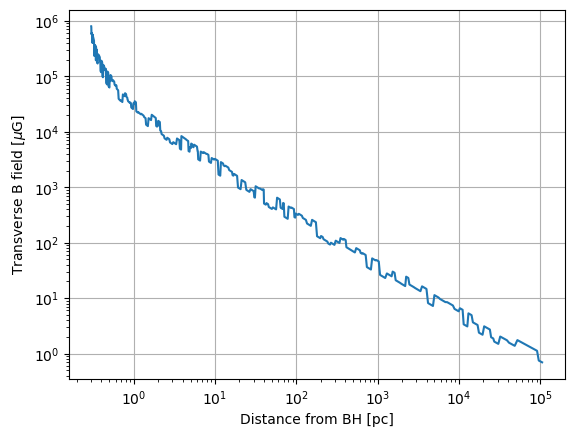

In [10]:
plt.loglog(ml.modules["JetHelicalTangled"].r, ml.modules["JetHelicalTangled"].B)
plt.grid(True)
plt.xlabel('Distance from BH [pc]')
plt.ylabel('Transverse B field [$\mu$G]')

The electron density used to propagate the ALP-photon beam is not the actual electron density, but rather the effective electron density of a cold plasma that would give the save effective photon mass as the non-thermal plasma of the jet. That is why it appears lower here than the actual electron density inputted.

Text(0.5, 0, 'Distance from BH [pc]')

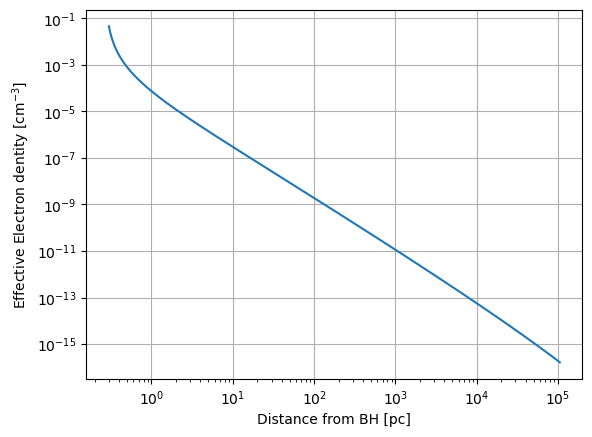

In [12]:
plt.loglog(ml.modules["JetHelicalTangled"].r, ml.modules["JetHelicalTangled"].nel)
plt.grid(True)
plt.ylabel('Effective Electron dentity [cm$^{-3}$]')
plt.xlabel('Distance from BH [pc]')

### Compute the photon-ALP mixing probability

Now we compute the mixing probability and plot the output. First we chance the ALP parameters:

In [13]:
ml.alp.m = 40.
ml.alp.g = 0.6

And then run the calculation to compute the mixing probabilities into the different photon polarzation states and the ALP state ($P_x, P_y$, and $P_a$)

In [14]:
px, py, pa = ml.run()

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixJetHelicalTangled'>


Plotting the output. Note that we access the module list by the index (an integer), rather then the name, simply for brevity.

(1, 2000)


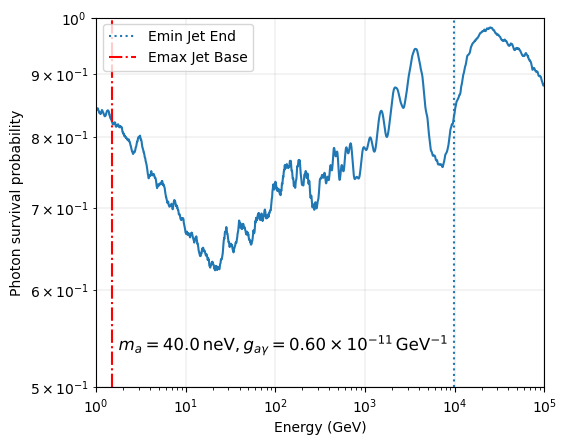

In [15]:
pgg = px + py  # the total photon survival probability

print (pgg.shape)

plt.plot(ml.EGeV, pgg[0])

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.2f}'\
             r' \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',**effect)

plt.axvline(transfer.EminGeV(ml.alp.m, ml.alp.g, ml.modules[0].nel[-1], ml.modules[0].B[-1]),
            ls=':',
            label='Emin Jet End')
plt.axvline(transfer.EmaxGeV(ml.alp.g, ml.modules[0].B[0]),
            ls='-.',
            color='red',
            label='Emax Jet Base')

plt.gca().set_ylim(0.5,1.)
plt.gca().set_xlim(min(ml.EGeV),max(ml.EGeV))
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)
plt.legend(loc = 'upper left', fontsize = 'medium')